<a href="https://colab.research.google.com/github/danifeerrer/CaliHousing/blob/main/CaliforniaHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url="https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")

  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


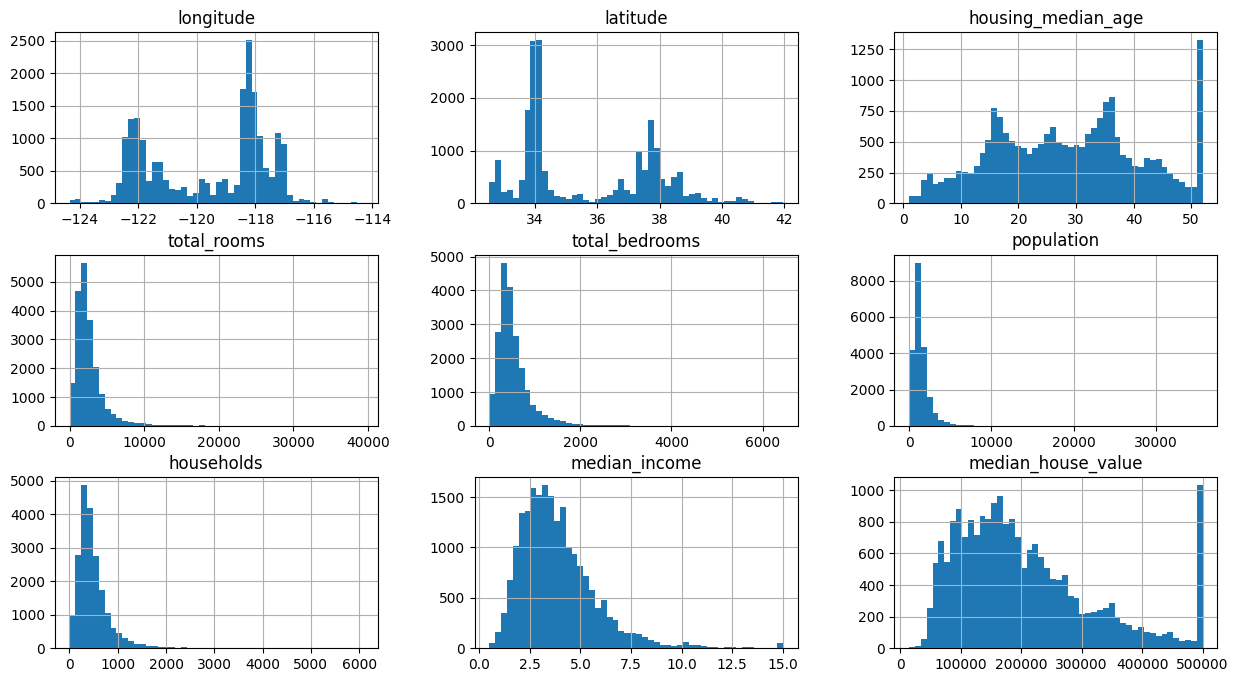

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [3]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(15,8))
plt.show()
housing.describe()

In [5]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(len(train_set))
print(len(test_set))


16512
4128


**OR, a better way would be the following**

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


**We've been told that the median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole data set.**




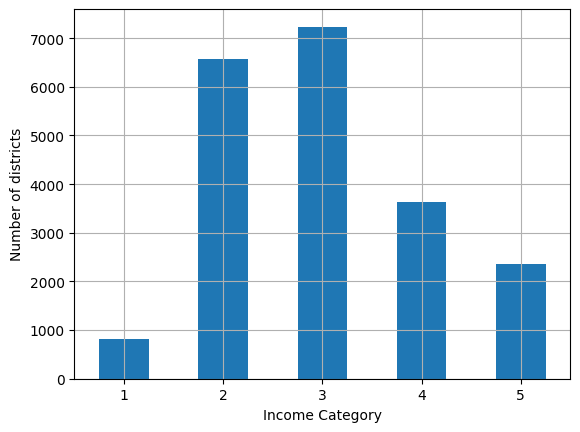

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


In [15]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])


housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()



La función train_test_split toma varios argumentos. En este caso, se le pasan los siguientes:

housing: Es el conjunto de datos que se desea dividir en conjuntos de entrenamiento y prueba.
test_size=0.2: Especifica el tamaño o proporción que se desea asignar al conjunto de prueba. Aquí se utiliza un tamaño del 20%, lo que significa que el conjunto de prueba contendrá el 20% de los datos, y el conjunto de entrenamiento contendrá el 80% restante.
stratify=housing["income_cat"]: Aquí se utiliza la columna "income_cat" como variable estratificadora. Esto significa que la división se realizará de manera que la proporción de las categorías en "income_cat" se mantenga en los conjuntos de entrenamiento y prueba. Esto es útil cuando queremos asegurarnos de que la distribución de una característica importante se mantenga en ambos conjuntos.
random_state=42: Este parámetro establece una semilla para la generación de números aleatorios, asegurando que la división del conjunto de datos sea reproducible.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


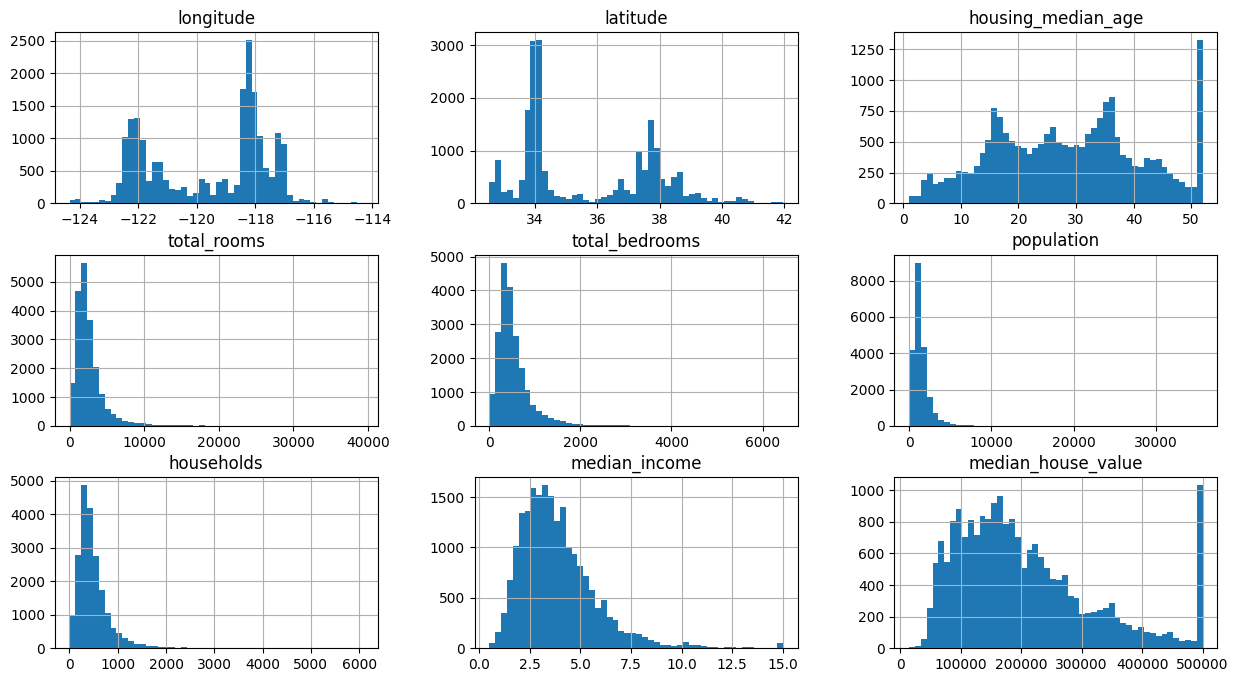

In [17]:
strat_train_set, strat_test_set = train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
housing.info()
housing.hist(bins=50, figsize=(15,8))
plt.show()